In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical 

Using TensorFlow backend.


In [2]:
#Load the data.
train = pd.read_csv('sample_data/mnist_train_small.csv')
test = pd.read_csv('sample_data/mnist_test.csv')

x_train = np.array(train.iloc[:,1:]).astype(float)
y_train = np.array(train.iloc[:,0])
x_test = np.array(test.iloc[:,1:]).astype(float)
#convert y to one hot encoding
y_test = to_categorical(np.array(test.iloc[:,0]),10)

x_train = x_train.reshape(x_train.shape[0],28,28,1)
x_test = x_test.reshape(x_test.shape[0],28,28,1)

#Split training and validation data
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.33)

#Convert y to one hot encoding
y_train =to_categorical(y_train,10)
y_val = to_categorical(y_val,10)


print(f'X_train:{x_train.shape}')
print(f'y_train:{y_train.shape}')
print(f'X_val:{x_val.shape}')
print(f'y_val:{y_val.shape}')
print(f'X_test:{x_test.shape}')



X_train:(13399, 28, 28, 1)
y_train:(13399, 10)
X_val:(6600, 28, 28, 1)
y_val:(6600, 10)
X_test:(9999, 28, 28, 1)


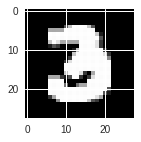

In [3]:
im = x_train[0].squeeze()
plt.figure(figsize=(2,2))
plt.imshow(im, cmap='gray')

In [0]:
class NN:

  #Function to build the network
  def build_nn(self):

    tf.reset_default_graph()
    with tf.variable_scope('modLeNet'):
      #Placeholders for our X and Y tensors. 
      # 28,28,1 bevause image is 28x28 and grayscale(1 channel)
      self.X = tf.placeholder(tf.float32, (None, 28, 28, 1),name='X')
      self.y = tf.placeholder(tf.float32,shape=[None,10],name='y')

      #LAyer 0
      cw0 = tf.get_variable(name='cw_0',shape=[3,3,1,6],dtype=tf.float32)
      conv0 = tf.nn.conv2d(self.X,cw0,[1,1,1,1],padding='SAME',name='conv_0')
      act0 = tf.nn.relu(conv0,name='act_0')
      pool0 = tf.nn.max_pool(act0,ksize=[1,2,2,1],strides = [1,2,2,1],name='pool_0',padding='VALID')

      #Layer 1
      cw1 = tf.get_variable(name='cw_1',shape=[5,5,6,16],dtype=tf.float32)
      conv1 =  tf.nn.conv2d(pool0,cw1,strides=[1,1,1,1],padding='VALID',name='conv_1')
      act1 = tf.nn.relu(conv1,name='act_1')
      pool1 = tf.nn.max_pool(act1,ksize=[1,2,2,1],strides = [1,2,2,1],name='pool_0',padding='VALID')

      #Layer 2 
      flat_ip = tf.layers.flatten(pool1) #flatten the output of previous layer
      w2 = tf.get_variable('w_2',shape=[400,120],dtype=tf.float32)
      b2 = tf.get_variable('b_2', shape=[120],dtype=tf.float32)
      
      
      fc_1 = flat_ip @ w2 + b2

      act2 = tf.nn.relu(fc_1)

      w3 = tf.get_variable('w_3',shape=[120,10],dtype=tf.float32)
      b3 = tf.get_variable('b_3', shape=[10],dtype=tf.float32)

      self.logits = act2 @ w3 + b3

      sm_logits = tf.nn.softmax(self.logits)
      
      #Cross Entropy Loss Calculation
      xent = tf.nn.softmax_cross_entropy_with_logits(labels = self.y, logits = self.logits, name='xent')
      self.loss = tf.reduce_mean(xent)
      
      correct_prediction = tf.equal(tf.argmax(sm_logits, 1), tf.argmax(self.y, 1))
      self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
      
      #We use ADAM here.
      self.optimizer = tf.train.AdamOptimizer()

      self.opt_op = self.optimizer.minimize(self.loss)



In [5]:
nn = NN()
nn.build_nn()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [6]:
#Testing initial accuracy and loss of the model.
s = tf.Session()
s.run(tf.initialize_all_variables())
train_loss, train_acc = s.run((nn.loss,nn.accuracy),feed_dict={nn.X:x_train,nn.y:y_train})
val_loss, val_acc = s.run((nn.loss,nn.accuracy),feed_dict={nn.X:x_val,nn.y:y_val})

print(f'Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f}')
print(f'Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}')

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Train Loss: 56.058, Train Acc: 0.091
Val Loss: 55.840, Val Acc: 0.087


In [0]:
hist = defaultdict(list)
test_loss=0
test_acc=0

In [0]:
#Function to train network. We do full batch training here.
def train():
  
  with tf.Session() as s:
    s.run(tf.initialize_all_variables())
    for i in range(300):
      if (i+1)%25 == 0:
        train_loss, train_acc = s.run((nn.loss,nn.accuracy),feed_dict={nn.X:x_train,nn.y:y_train})
        val_loss, val_acc = s.run((nn.loss,nn.accuracy),feed_dict={nn.X:x_val,nn.y:y_val})
        print(f'Iteration {i+1}')
        print(f'Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f}')
        print(f'Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}')
      #Run the optimazation step.
      _ = s.run(nn.opt_op,feed_dict={nn.X:x_train,nn.y:y_train})
      
      train_loss, train_acc = s.run((nn.loss,nn.accuracy),feed_dict={nn.X:x_train,nn.y:y_train})
      val_loss, val_acc = s.run((nn.loss,nn.accuracy),feed_dict={nn.X:x_val,nn.y:y_val})
      
      #Add the losses and accuracies to history
      hist['train_loss'].append(train_loss)
      hist['train_acc'].append(train_acc)
      hist['val_loss'].append(val_loss)
      hist['val_acc'].append(val_acc)
      
    test_loss, test_acc = s.run((nn.loss,nn.accuracy),feed_dict={nn.X:x_test,nn.y:y_test})
    print(f'Test Loss: {test_loss}, Test Acc: {test_acc}')

In [9]:
train()

Iteration 25
Train Loss: 2.194, Train Acc: 0.661
Val Loss: 2.171, Val Acc: 0.663
Iteration 50
Train Loss: 0.848, Train Acc: 0.834
Val Loss: 0.887, Val Acc: 0.826
Iteration 75
Train Loss: 0.462, Train Acc: 0.898
Val Loss: 0.549, Val Acc: 0.883
Iteration 100
Train Loss: 0.285, Train Acc: 0.931
Val Loss: 0.411, Val Acc: 0.909
Iteration 125
Train Loss: 0.189, Train Acc: 0.952
Val Loss: 0.346, Val Acc: 0.922
Iteration 150
Train Loss: 0.132, Train Acc: 0.967
Val Loss: 0.312, Val Acc: 0.932
Iteration 175
Train Loss: 0.093, Train Acc: 0.975
Val Loss: 0.293, Val Acc: 0.935
Iteration 200
Train Loss: 0.066, Train Acc: 0.983
Val Loss: 0.283, Val Acc: 0.939
Iteration 225
Train Loss: 0.048, Train Acc: 0.989
Val Loss: 0.278, Val Acc: 0.941
Iteration 250
Train Loss: 0.036, Train Acc: 0.992
Val Loss: 0.274, Val Acc: 0.944
Iteration 275
Train Loss: 0.027, Train Acc: 0.995
Val Loss: 0.273, Val Acc: 0.946
Iteration 300
Train Loss: 0.020, Train Acc: 0.997
Val Loss: 0.272, Val Acc: 0.948
Test Loss: 0.263069

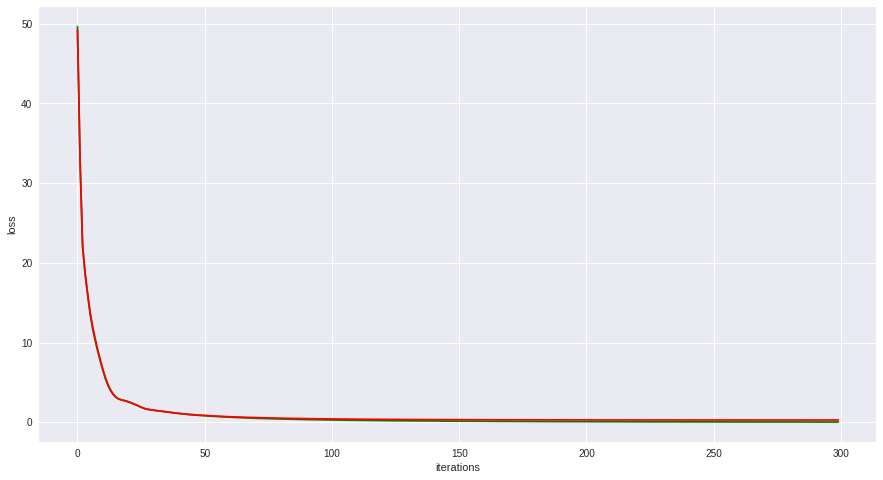

In [10]:
#Plot loss vs iteration
plt.figure(figsize=(15,8))

plt.plot(hist['train_loss'], color='green', label='train_loss')
plt.plot(hist['val_loss'], color='red', label='val_loss')
plt.xlabel('iterations')
plt.ylabel('loss')

plt.show()

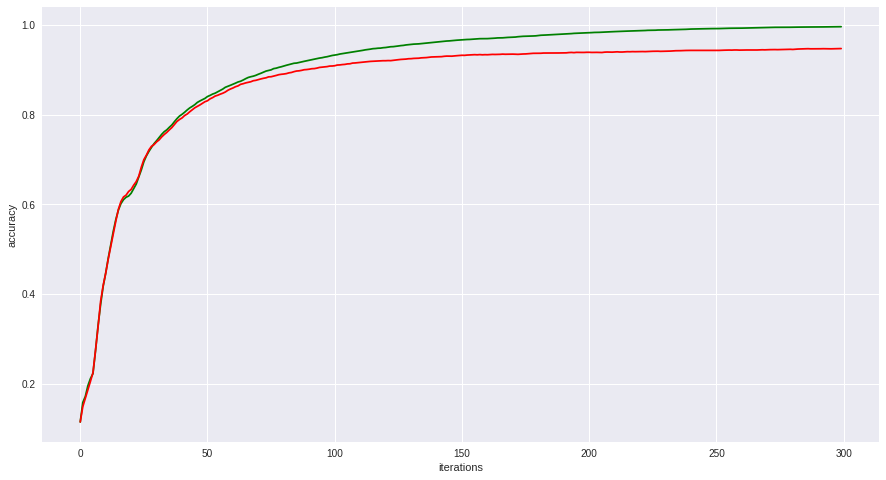

In [11]:
#Plot accuracy vs iteration
plt.figure(figsize=(15,8))

plt.plot(hist['train_acc'], color='green', label='train_acc')
plt.plot(hist['val_acc'], color='red', label='val_acc')
plt.xlabel('iterations')
plt.ylabel('accuracy')

plt.show()